In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Net1


In [6]:
torch.cuda.is_available()

True

In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 130MB/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 12.5MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 84.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.45MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net1().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
       BatchNorm2d-6           [-1, 16, 28, 28]              32
              ReLU-7           [-1, 16, 28, 28]               0
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             128
      BatchNorm2d-11            [-1, 8, 14, 14]              16
             ReLU-12            [-1, 8, 14, 14]               0
          Dropout-13            [-1, 8, 14, 14]               0
           Conv2d-14            [-

# Training

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Net1().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9)
# # optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
# scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
EPOCHS = 15
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.25855353474617004 Batch_id=468 Accuracy=72.79: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]



Test set: Average loss: 0.1903, Accuracy: 9596/10000 (95.96%)

EPOCH: 1


Loss=0.11642199009656906 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:06<00:00, 76.38it/s] 



Test set: Average loss: 0.0893, Accuracy: 9759/10000 (97.59%)

EPOCH: 2


Loss=0.0926324799656868 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:06<00:00, 76.21it/s]  



Test set: Average loss: 0.0854, Accuracy: 9784/10000 (97.84%)

EPOCH: 3


Loss=0.08368297666311264 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:06<00:00, 77.15it/s] 



Test set: Average loss: 0.0521, Accuracy: 9864/10000 (98.64%)

EPOCH: 4


Loss=0.08964157104492188 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:06<00:00, 76.88it/s] 



Test set: Average loss: 0.0463, Accuracy: 9873/10000 (98.73%)

EPOCH: 5


Loss=0.03608180209994316 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:06<00:00, 77.01it/s] 



Test set: Average loss: 0.0413, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.022994013503193855 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:06<00:00, 76.19it/s]



Test set: Average loss: 0.0741, Accuracy: 9779/10000 (97.79%)

EPOCH: 7


Loss=0.017664622515439987 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:06<00:00, 77.07it/s]



Test set: Average loss: 0.0473, Accuracy: 9852/10000 (98.52%)

EPOCH: 8


Loss=0.10501742362976074 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:06<00:00, 77.26it/s] 



Test set: Average loss: 0.0466, Accuracy: 9853/10000 (98.53%)

EPOCH: 9


Loss=0.03760536387562752 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:06<00:00, 77.30it/s] 



Test set: Average loss: 0.0374, Accuracy: 9877/10000 (98.77%)

EPOCH: 10


Loss=0.022799929603934288 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:06<00:00, 77.70it/s]



Test set: Average loss: 0.0334, Accuracy: 9892/10000 (98.92%)

EPOCH: 11


Loss=0.03743256255984306 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:06<00:00, 77.31it/s]  



Test set: Average loss: 0.0347, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=0.022677982226014137 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:06<00:00, 77.09it/s]



Test set: Average loss: 0.0300, Accuracy: 9896/10000 (98.96%)

EPOCH: 13


Loss=0.02302681654691696 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:06<00:00, 76.49it/s] 



Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99.08%)

EPOCH: 14


Loss=0.05837234482169151 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:06<00:00, 77.73it/s]  



Test set: Average loss: 0.0296, Accuracy: 9906/10000 (99.06%)



Matplotlib is building the font cache; this may take a moment.


Text(0.5, 1.0, 'Test Accuracy')

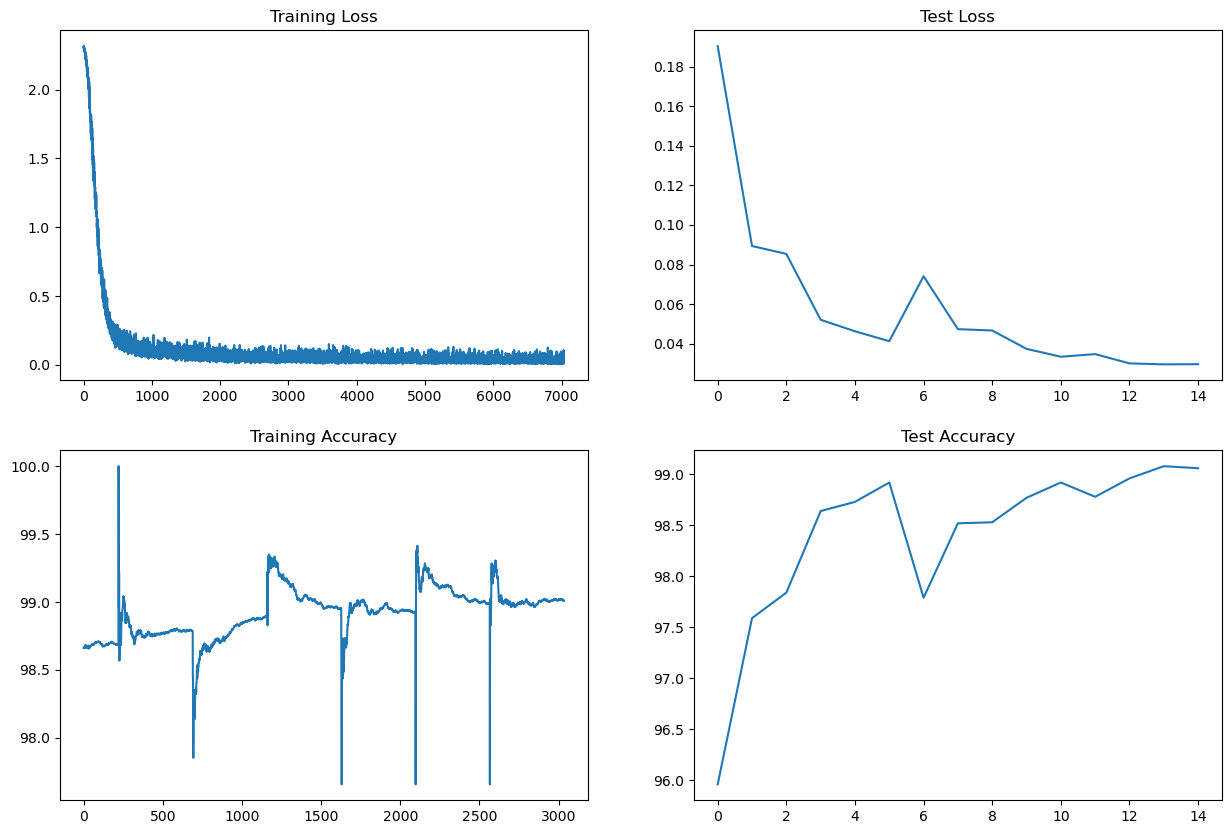

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [16]:
fig.savefig('exp1.png')

In [19]:

import matplotlib.pyplot as plt
import numpy as np
def evaluate_model(model: nn.Module, loader, device: torch.device):
    cols, rows = 4,6
    figure = plt.figure(figsize=(20, 20))
    for i in range(1, cols * rows + 1):
        k = np.random.randint(0, len(loader.dataset)) # random points from test dataset
    
        img, label = loader.dataset[k] # separate the image and label
        img = img.unsqueeze(0) # adding one dimention
        pred=  model(img.to(device)) # Prediction 

        figure.add_subplot(rows, cols, i) # making the figure 
        plt.title(f"Predcited label {pred.argmax().item()}\n True Label: {label}") # title of plot
        plt.axis("off") # hiding the axis
        plt.imshow(img.squeeze(), cmap="gray") # showing the plot

    plt.show()
    plt.savefig('eval_1.png')

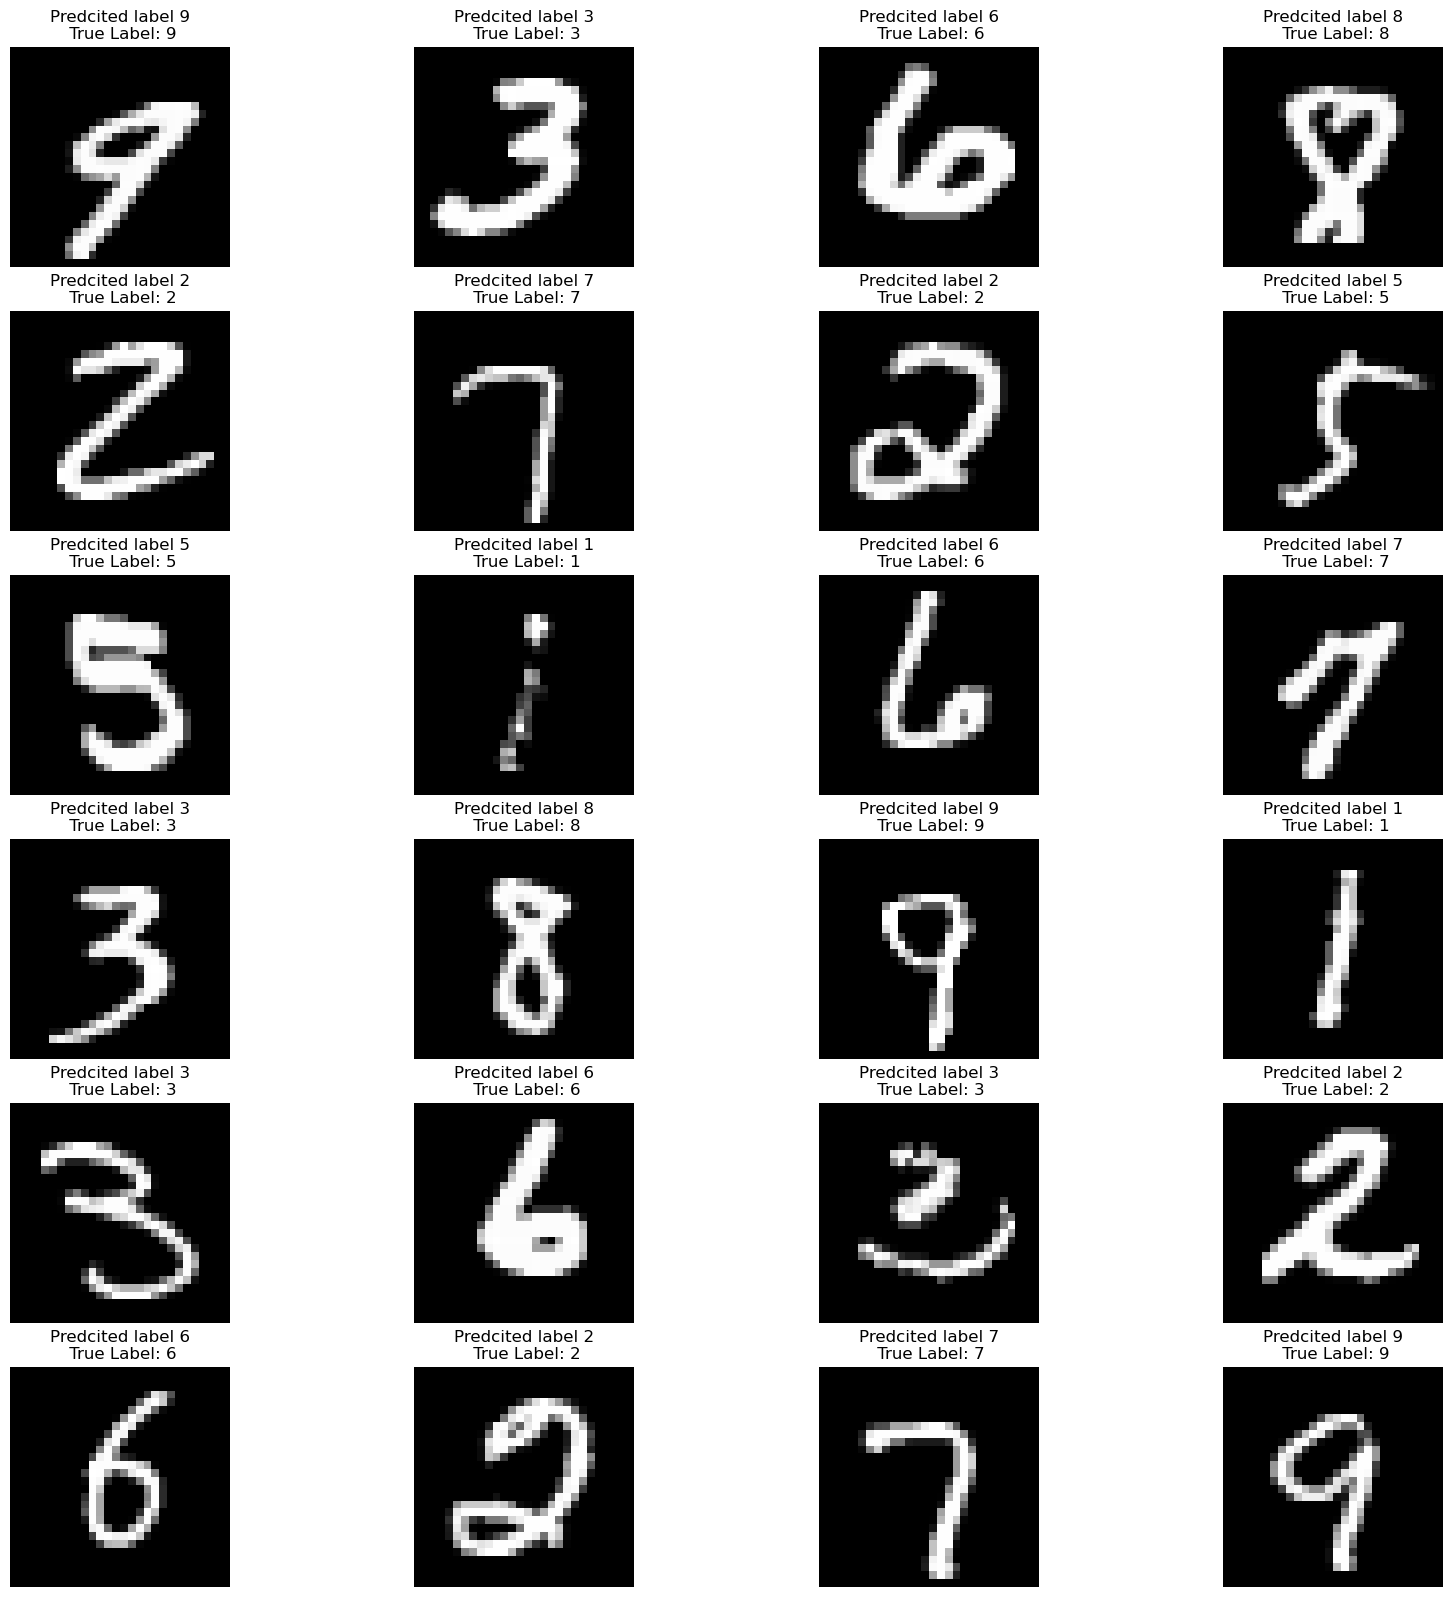

In [21]:
evaluate_model(model, test_loader, device)

In [20]:
!hostname

ip-172-31-39-183


In [22]:
! cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.5 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.5 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy
